In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, MaxPooling1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import compute_class_weight
from sklearn.utils import class_weight
from tensorflow.keras.metrics import Precision, Recall, AUC, SparseCategoricalAccuracy
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import movmus as mm

import json
import os
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv1D, BatchNormalization, MaxPooling1D, GlobalAveragePooling1D, 
    Dropout, Dense, Input, Concatenate
)
from tensorflow.keras.models import Model

# user context model

### opening and transforming metadata

In [2]:
train_data, val_data, test_data = mm.load_data_npz('EMG_1000_data.npz')

shape of training data: (2720, 1000, 7)
shape of validation data: (502, 1000, 7)
shape of test data: (661, 1000, 7)


In [3]:
train_labels, val_labels, test_labels = mm.load_data_npz('labels.npz')

shape of training data: (2720, 2)
shape of validation data: (502, 2)
shape of test data: (661, 2)


In [4]:
train_subject_context = mm.load_metadata_npz('subject_context_train.npz')
val_subject_context = mm.load_metadata_npz('subject_context_val.npz')
test_subject_context = mm.load_metadata_npz('subject_context_test.npz')

print('Context data shapes:', train_subject_context.shape, val_subject_context.shape, test_subject_context.shape)

Context data shapes: (2720, 6) (502, 6) (661, 6)


In [5]:
train_subject_context = train_subject_context.iloc[:, 1:]
val_subject_context = val_subject_context.iloc[:, 1:]
test_subject_context = test_subject_context.iloc[:, 1:]
print('Context data shapes:', train_subject_context.shape, val_subject_context.shape, test_subject_context.shape)

Context data shapes: (2720, 5) (502, 5) (661, 5)


### model parameters

In [6]:
batch_size = 68
epochs = 300
num_samples = len(train_data)  # Number of training samples
print('Number of training samples:', num_samples)


Number of training samples: 2720


In [7]:
# Define the learning rate schedule
initial_learning_rate = 0.001
decay_steps = (num_samples/batch_size)*epochs  # 2752 samples/ 86 bs = 32 --> 32 * 250 epochs = 8000 steps
print("Decay steps:", decay_steps)
alpha = 0.01 

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    alpha=alpha
)

Decay steps: 12000.0


In [8]:
from tensorflow.keras.callbacks import Callback

class LearningRateLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        print(f" - lr: {lr}")

DEFINING THE ENTRIES

In [9]:

#DATA EMG
X_trainEMG = train_data
print('emg data shape: ' + str(X_trainEMG.shape))
X_valEMG = val_data
print('emg val data shape: ' + str(X_valEMG.shape))
print('')
#DATA CONTEXT
X_trainContext = train_subject_context.to_numpy()
print('emg context shape: ' + str(X_trainContext.shape))

X_valContext = val_subject_context.to_numpy()
print('emg val context shape: ' + str(X_valContext.shape))
print('')
#LABELS
y_trainEMG = train_labels
y_valEMG = val_labels
print('emg labels shape: ' + str(y_trainEMG.shape))
print('emg val labels shape: ' + str(y_valEMG.shape))


emg data shape: (2720, 1000, 7)
emg val data shape: (502, 1000, 7)

emg context shape: (2720, 5)
emg val context shape: (502, 5)

emg labels shape: (2720, 2)
emg val labels shape: (502, 2)


### model creation

Name of the model:
- S_C : subject context
- T_C : task context

'+'

- CUSTOM : from parent EMG model M_20
- BASE : from parent EMG model M_28

'+'

- Model number


In [31]:
model_name = 'BASE_SUBJ_CONTEXT_MODEL_4'
model_folder = '.\\MODELS_SC'
plot_folder = '.\\PLOTS_SC'


In [37]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv1D, BatchNormalization, MaxPooling1D, GlobalAveragePooling1D, 
    Dropout, Dense, Input, concatenate
)
from tensorflow.keras.models import Model

# Define the EMG signal branch
emg_input = Input(shape=(1000, 7), name='emg_input')
# try 16 32 or 32 32
x = Conv1D(filters=16, kernel_size=5, padding='valid', activation='relu')(emg_input)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=32, kernel_size=5, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
x = GlobalAveragePooling1D()(x)
#x = Dropout(0.2)(x)

# Define the context branch
context_input = Input(shape=(5,), name='context_input') 

y = Dense(64, activation='relu')(context_input)
#y = Dense(64, activation='relu')(y)
#y= BatchNormalization()(y)
#y = Dense(128, activation='relu')(context_input) #if CUSTOM LAYERS
#y = Dropout(0.1)(y)

#add bn possibly add dropout
y = Dense(32, activation='relu')(y)
#y = Dense(64, activation='relu')(y) #if CUSTOM LAYERS
#y = BatchNormalization()(y)
#y = Dropout(0.2)(y)

#add bn possibly add dropout

# Concatenate the branches
combined = concatenate([x, y])

# custom layers
#z = Dense(64, activation='relu',)(combined)
#z = BatchNormalization()(z)

# Add final layers
z = Dropout(0.2)(combined)
z = Dense(32, activation='relu', kernel_regularizer=l2(0.02))(z)
output = Dense(2, activation='softmax')(z)

# Create the model
model = Model(inputs=[emg_input, context_input], outputs=output)

In [38]:
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=lr_schedule),
    metrics=['accuracy', 'Precision', 'Recall', 'AUC'])


In [39]:
print(f'X_trainEMG shape: {X_trainEMG.shape}')
print(f'X_trainContext shape: {X_trainContext.shape}')
print(f'y_trainEMG shape: {y_trainEMG.shape}')

X_trainEMG shape: (2720, 1000, 7)
X_trainContext shape: (2720, 5)
y_trainEMG shape: (2720, 2)


In [40]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ emg_input           │ (None, 1000, 7)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 996, 16)   │        576 │ emg_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 996, 16)   │         64 │ conv1d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 498, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 494, 32)   │      2,592 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_input       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 494, 32)   │        128 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 64)        │        384 │ context_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 32)        │      2,080 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 64)        │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 32)        │      2,080 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 2)         │         66 │ dense_15[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,970 (31.13 KB)

 Trainable params: 7,874 (30.76 KB)

 Non-trainable params: 96 (384.00 B)

### training

In [41]:
start_time = time.time()
history = model.fit(
    x=[X_trainEMG, X_trainContext],  # Input data: EMG and context
    y=y_trainEMG,                    # Labels
    validation_data=([X_valEMG, X_valContext], y_valEMG),  # Validation data
    epochs=epochs,                        
    batch_size=batch_size,                   
    callbacks=[
        LearningRateLogger()#,                       
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)
end_time = time.time()

Epoch 1/300
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.7096 - Precision: 0.6579 - Recall: 0.6579 - accuracy: 0.6579 - loss: 1.4375 - lr: 0.0009999729227274656
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - AUC: 0.7188 - Precision: 0.6657 - Recall: 0.6657 - accuracy: 0.6657 - loss: 1.4234 - val_AUC: 0.5561 - val_Precision: 0.5339 - val_Recall: 0.5339 - val_accuracy: 0.5339 - val_loss: 1.2764
Epoch 2/300
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.8519 - Precision: 0.7862 - Recall: 0.7862 - accuracy: 0.7862 - loss: 1.0167 - lr: 0.0009998914320021868
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.8515 - Precision: 0.7857 - Recall: 0.7857 - accuracy: 0.7857 - loss: 1.0117 - val_AUC: 0.6314 - val_Precision: 0.5339 - val_Recall: 0.5339 - val_accuracy: 0.5339 - val_loss: 1.0675
Epoch 3/300
38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.8689 - Precision: 0.7983 - Recall: 0.7983 - accuracy: 0.7983 - loss: 0.8040 - lr: 0.0009997556917369366
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC

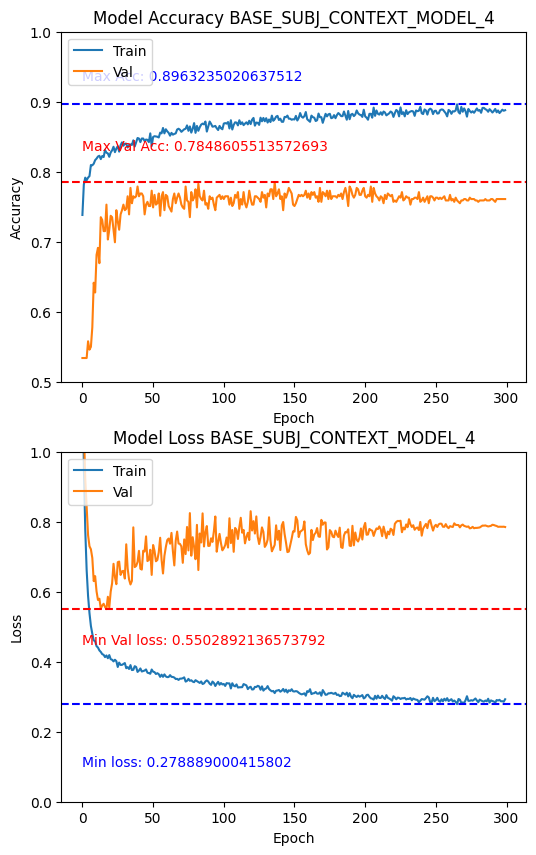

In [42]:
fig, axs = plt.subplots(2,1, figsize=(6, 10))
    
# Subplot 1: Plot training & validation accuracy values
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model Accuracy ' + model_name)

axs[0].axhline(y=max(history.history['accuracy']), color='b', linestyle='--')  # Add horizontal line at y=0.75
axs[0].text(0,0.93, f'Max Acc: {max(history.history["accuracy"])}', color='b')  # Add text annotation with the max value

axs[0].axhline(y=max(history.history['val_accuracy']), color='r', linestyle='--')  # Add horizontal line at y=0.75
axs[0].text(0,0.83, f'Max Val Acc: {max(history.history["val_accuracy"])}', color='red')  # Add text annotation with the max value
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Val'], loc='upper left')
axs[0].set_ylim(0.5, 1)

# Subplot 2: Plot training & validation loss values
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model Loss ' + model_name)
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Val'], loc='upper left')
axs[1].set_ylim(0, 1)

axs[1].axhline(y=min(history.history['val_loss']), color='r', linestyle='--')  # Add horizontal line at y=0.75
axs[1].text(0,0.45, f'Min Val loss: {min(history.history["val_loss"])}', color='red')  # Add text annotation with the max value

axs[1].axhline(y=min(history.history['loss']), color='b', linestyle='--')  # Add horizontal line at y=0.75
axs[1].text(0,0.1, f'Min loss: {min(history.history["loss"])}', color='b')  # Add text annotation with the max value

# Save the figure with subplots
plt.savefig(f'{plot_folder}\\ACC_LOSS_{model_name}.png')

# Show the plot
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


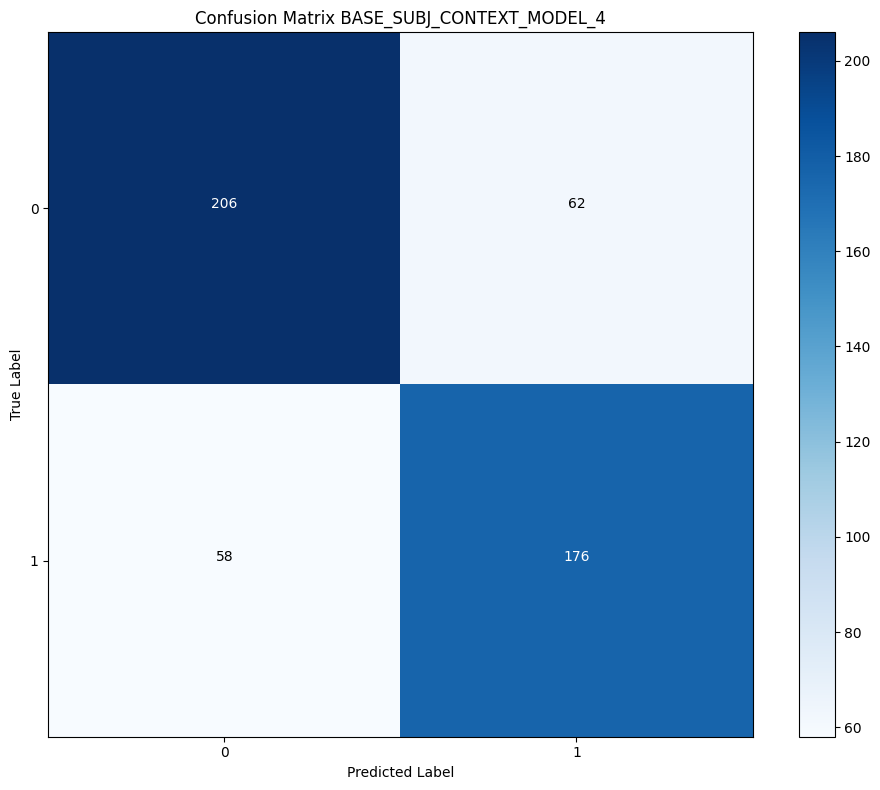

In [43]:
#import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical

# Assuming y_val is one-hot encoded, convert it back to class labels
y_true_classes = np.argmax(y_valEMG, axis=1)

# Make predictions on the validation set
y_pred = model.predict([X_valEMG, X_valContext])

# Convert predictions from sigmoid output to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
cmap = plt.cm.Blues
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion Matrix ' + model_name)
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_true_classes)))  # this adapts to the number of classes dynamically
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

# Labeling the axes
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations inside the squares
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.savefig(f'{plot_folder}\\CM_{model_name}.png')

plt.show()


In [44]:
mm.save_model(model, model_folder, model_name)


Model saved to .\MODELS_SC\BASE_SUBJ_CONTEXT_MODEL_4.keras


In [45]:
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")
print(f"Training time: {training_time/60} minutes")
# Convert the history object to a dictionary
history_dict = history.history

# Add the training time to the dictionary
history_dict['training_time'] = training_time
history_dict['model'] = model_name
history_dict['batch_size'] = batch_size
history_dict['epochs'] = epochs
history_dict['learning_rate'] = initial_learning_rate
history_dict['decay_steps'] = decay_steps
history_dict['alpha'] = alpha
history_dict['loss_function'] = 'binary_crossentropy'
history_dict['optimizer'] = 'Adam'

# Save the dictionary to a JSON file

mm.save_history(history_dict, model_folder, model_name)

Training time: 183.2985668182373 seconds
Training time: 3.0549761136372884 minutes
History saved to .\MODELS_SC\BASE_SUBJ_CONTEXT_MODEL_4_history.json


In [46]:

print('output shape')
print(y_pred.shape)
print('output')
print(y_pred)

output shape
(502, 2)
output
[[2.0756181e-04 9.9979240e-01]
 [2.1191074e-02 9.7880894e-01]
 [4.0452787e-07 9.9999964e-01]
 ...
 [9.9788034e-01 2.1196797e-03]
 [4.5226514e-01 5.4773492e-01]
 [9.9917370e-01 8.2627800e-04]]
